## PD - Probability of Default

This notebook aims to come up with a general methodology for selecting features for PD model - as well as for finding the best categories for the features.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from credit_risk_modeling.cleaning import DatetimeConverter, NumericExtractor
from credit_risk_modeling.feature_engineering import TimeSinceCalculator, OHECategoriesCreator
from credit_risk_modeling.eda import compute_woe, plot_woe_by_category

#### Get data and select columns

In [2]:
selected_cols = [
    "id", "member_id", "loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", "emp_length", 
    "home_ownership", "annual_inc", "issue_d", "loan_status", "purpose", "addr_state", "dti", "delinq_2yrs", 
    "earliest_cr_line", "verification_status", "initial_list_status", "inq_last_6mths", "open_acc", "pub_rec", 
    "total_acc", "acc_now_delinq", "total_rev_hi_lim"
]

In [3]:
df = pd.read_csv("../data/loan_data.csv")
df = df.loc[:, selected_cols]

/Users/gfluz94/.credit-risk/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Clean, Preprocess and Create Features

In [4]:
datetime_cols = ["earliest_cr_line", "issue_d"]
datetime_format = "%b-%y"
time_unit = "month"
reference_date = datetime(2017, 12, 1)

datetime_converter = DatetimeConverter(
    field_names=datetime_cols,
    datetime_format=datetime_format
)
df = datetime_converter.transform(df)

for datetime_col in datetime_cols:
    time_since_calculator = TimeSinceCalculator(
        field_name=datetime_col, reference_date=reference_date, time_unit=time_unit, winsorize_max=True,
    )
    df = time_since_calculator.transform(df)

In order for us to continue with the analysis, we just need to carry out two additional steps:

* Define target variable

In [5]:
DEFAULT_CATEGORIES = [
    "Charged Off",
    "Late (31-120 days)",
    "Default",
    "Does not meet the credit policy. Status:Charged Off"
]
TARGET_VARIABLE = "default"

df[TARGET_VARIABLE] = df["loan_status"].isin(DEFAULT_CATEGORIES).astype(float)
(df[TARGET_VARIABLE].value_counts() / len(df)).apply(lambda x: f"{100*x:.2f}%")

0.0    89.07%
1.0    10.93%
Name: default, dtype: object

* Split our dataset into training and test, so that we avoid data leakage at all costs.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=99, stratify=df[TARGET_VARIABLE])

#### Categorical Features

It is time for us now to take a closer look at categorical variables and, according to WoE analysis, select the best categories for each feature.

We are going to analyze the following variables:

* `grade`
* `home_ownership`
* `addr_state`
* `verification_status`
* `purpose`
* `initial_list_status`

In [7]:
transformers = []

1. `grade`

In [8]:
variable = "grade"

In [9]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


B    109603
C    100372
D     61548
A     59796
E     28514
F     10502
G      2693
Name: grade, dtype: int64


In [10]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
grade,,,,,,,
A,57506,2290,59796,0.173078,0.056163,-1.125482,0.29095
B,100983,8620,109603,0.303933,0.211409,-0.363012,0.29095
C,88788,11584,100372,0.267229,0.284103,0.061228,0.29095
D,52076,9472,61548,0.156736,0.232305,0.393491,0.29095
E,22981,5533,28514,0.069167,0.135699,0.673917,0.29095
F,7960,2542,10502,0.023958,0.062344,0.956377,0.29095
G,1960,733,2693,0.005899,0.017977,1.114301,0.29095


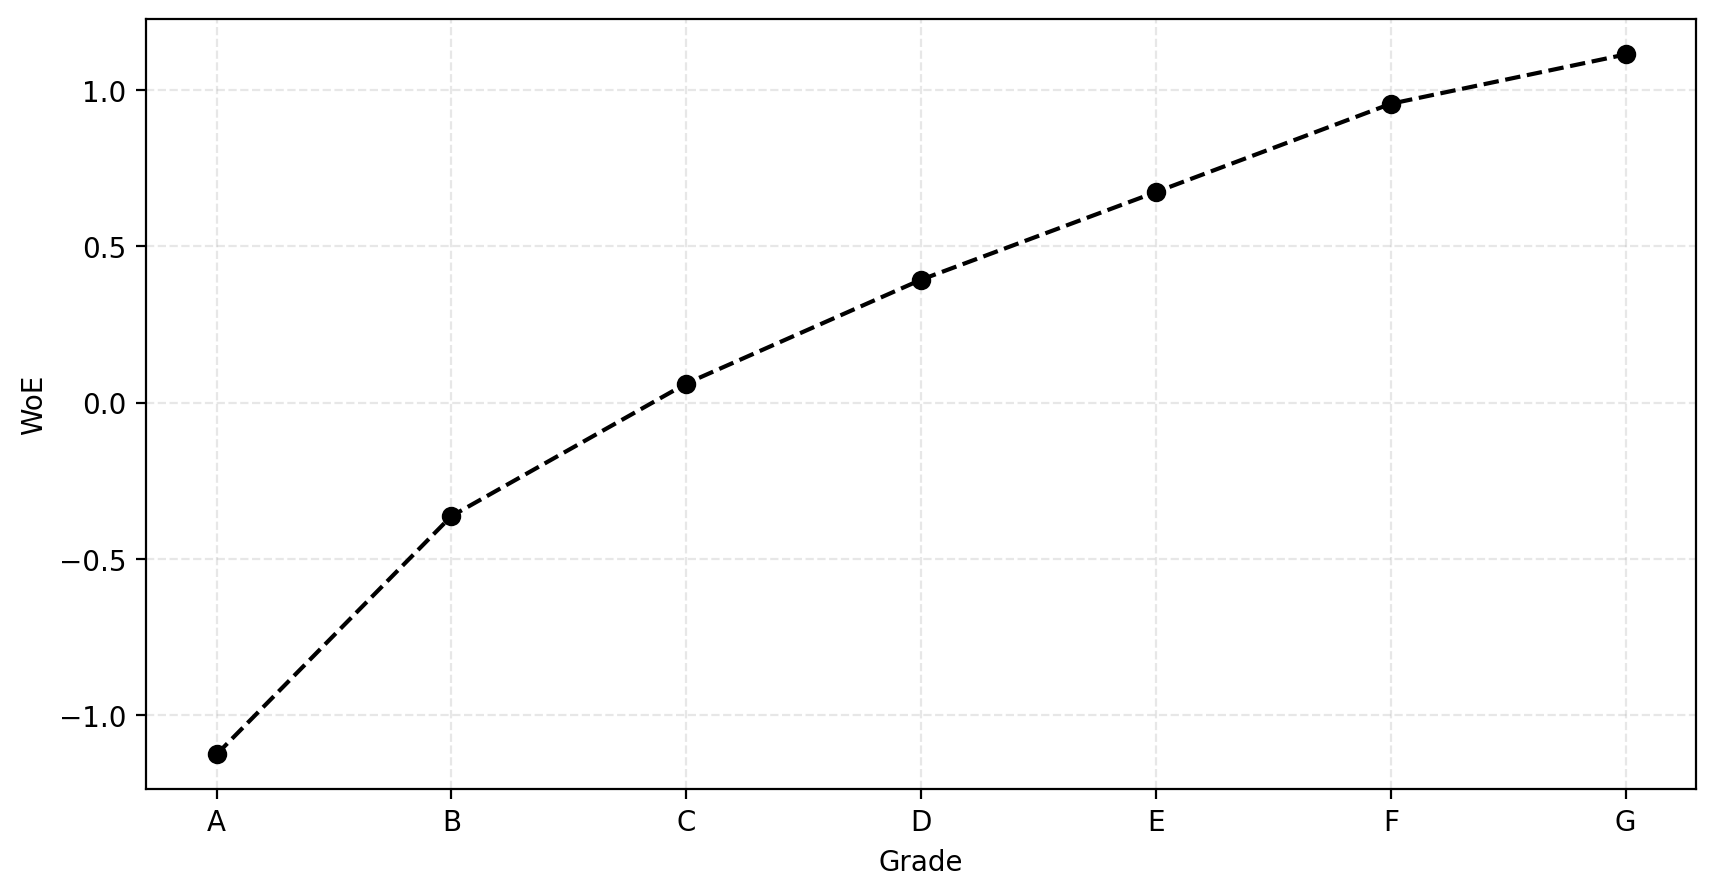

In [11]:
plot_woe_by_category(woe_df)

Based on the analysis above, we are going to keep the current seven categories (A -> G). We can notice that the curve almost increases monotonically, from A to G, meaning that A is the best score and G is the worst one.

In [15]:
final_categories = {
    "A": ["A"],
    "B": ["B"],
    "C": ["C"],
    "D": ["D"],
    "E": ["E"],
    "F": ["F"],
    "G": ["G"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)